In [1]:
import random
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR

In [2]:
TRAIN_CSV = "/kaggle/input/sel-dataset/train_split.csv"
TEST_CSV  = "/kaggle/input/sel-dataset/test_split.csv"

SELECTED_SENSORS = [
    'A_x [g]_x', 'A_y [g]_x', 'A_z [g]_x',
    'A_x [g]_y', 'A_y [g]_y', 'A_z [g]_y',
    'M_x [gauss]', 'M_y [gauss]', 'M_z [gauss]',
    'G_x [mdps]', 'G_y [mdps]', 'G_z [mdps]',
    'PRESS', 'TEMP'
]
WINDOW_SIZE = 600
BATCH_SIZE = 32
SAMPLING_FREQ = 200
ADD_FEATS = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SensorDataset(Dataset):
    def __init__(self, windows, io_labels, scene_labels, scaler, io_encoder, scene_encoder, is_train=False):
        self.scaler = scaler
        self.io_label_encoder = io_encoder
        self.scene_label_encoder = scene_encoder
              
        windows_reshaped = windows.reshape(len(windows), -1)
        
        if is_train:
            # if training set, FIT and transform
            windows_scaled = self.scaler.fit_transform(windows_reshaped)
            self.io_labels = self.io_label_encoder.fit_transform(io_labels)
            self.scene_labels = self.scene_label_encoder.fit_transform(scene_labels)
        else:
            # otherwise, just transform
            windows_scaled = self.scaler.transform(windows_reshaped)
            self.io_labels = self.io_label_encoder.transform(io_labels)
            self.scene_labels = self.scene_label_encoder.transform(scene_labels)
            
        self.windows = windows_scaled.reshape(windows.shape)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        tensor_data = torch.FloatTensor(self.windows[idx])
        return (tensor_data.permute(1, 0), 
                torch.LongTensor([self.io_labels[idx]]),
                torch.LongTensor([self.scene_labels[idx]]))

In [4]:
full_train_df = pd.read_csv(TRAIN_CSV)
test_df_original = pd.read_csv(TEST_CSV)
master_df = pd.concat([full_train_df, test_df_original], ignore_index=True)

# extract all windows from the full dataset
def create_all_windows(data, window_size, sensors):
    windows = []
    io_labels = []
    scene_labels = []
    step_size = window_size // 2

    for i in range(0, len(data) - window_size, step_size):
        window_df = data.iloc[i:i + window_size]
        io_unique = window_df['I/O Detection'].unique()
        scene_unique = window_df['Scene Identification'].unique()
        
        if len(io_unique) == 1 and len(scene_unique) == 1:
            windows.append(window_df[sensors].values)
            io_labels.append(io_unique[0])
            scene_labels.append(scene_unique[0])
            
    return np.array(windows), np.array(io_labels), np.array(scene_labels)

all_windows, all_io_labels, all_scene_labels = create_all_windows(master_df, WINDOW_SIZE, SELECTED_SENSORS)

print(f"Totale finestre valide create: {len(all_windows)}")

# stratify on scene labels to have a good balance
train_windows, val_test_windows, train_io, val_test_io, train_scene, val_test_scene = train_test_split(
    all_windows, all_io_labels, all_scene_labels,
    test_size=0.3,
    random_state=42,
    stratify=all_scene_labels
)

val_windows, test_windows, val_io, test_io, val_scene, test_scene = train_test_split(
    val_test_windows, val_test_io, val_test_scene,
    test_size=0.5,
    random_state=42,
    stratify=val_test_scene
)

print(f"Finestre di Training: {len(train_windows)}")
print(f"Finestre di Validazione: {len(val_windows)}")
print(f"Finestre di Test: {len(test_windows)}")

scaler = StandardScaler()
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

train_ds = SensorDataset(train_windows, train_io, train_scene, scaler, io_encoder, scene_encoder, is_train=True)
validation_ds = SensorDataset(val_windows, val_io, val_scene, scaler, io_encoder, scene_encoder, is_train=False)
test_ds = SensorDataset(test_windows, test_io, test_scene, scaler, io_encoder, scene_encoder, is_train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print("\nDataLoaders creati con successo usando il metodo ibrido.")

Totale finestre valide create: 16034
Finestre di Training: 11223
Finestre di Validazione: 2405
Finestre di Test: 2406

DataLoaders creati con successo usando il metodo ibrido.


In [ ]:
# 1D conv
class EarlyExitCNN1D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, exit_thresholds):
        super().__init__()
        self.if_train = if_train
        seq_len, n_sensors = train_shape

        # ---- 1D backbone ----
        self.backbone = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=n_sensors, out_channels=16, kernel_size=6, stride=3, padding=2),
                nn.BatchNorm1d(16),
                nn.ReLU(),
                nn.Dropout1d(0.3)
            ),
            nn.Sequential(
                nn.Conv1d(16, 24, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(24),
                nn.ReLU(),
                nn.Dropout(0.3)
            ),
            nn.Sequential(
                nn.Conv1d(24, 32, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(0.3)
            ),
        ])

        # ---- exit heads ----
        # each pools the time dimension down to 1 before the linear
        self.exits = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),   # -> (B, 16, 1)
                nn.Flatten(),              # -> (B, 16)
                # nn.Dropout(0.3),
                nn.Linear(16, n_io),       # IO classifier
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),   # -> (B, 32, 1)
                nn.Flatten(),              # -> (B, 32)
                # nn.Dropout(0.3),
                nn.Linear(24, n_scene),    # Scene classifier @ exit1
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),   # -> (B, 64, 1)
                nn.Flatten(),              # -> (B, 64)
                # nn.Dropout(0.3),
                nn.Linear(32, n_scene),    # Scene classifier @ exit2
            ),
        ])

        # ---- adapters for fusion ----
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io, n_scene),  # out0 → exit1
            nn.Linear(n_scene, n_scene),  # exit1 self
            nn.Linear(n_io, n_scene),  # out0 → exit2
            nn.Linear(n_scene, n_scene),  # out1 → exit2
            nn.Linear(n_scene, n_scene),  # exit2 self
        ])

        # confidence thresholds
        self.exit_thr0 = torch.tensor(exit_thresholds[0], dtype=torch.float32, device=device)
        self.exit_thr1 = torch.tensor(exit_thresholds[1], dtype=torch.float32, device=device)

    def exit_confidence_based(self, logits, thr):
        probs = F.softmax(logits, dim=-1)
        return probs.max(dim=-1)[0] > thr

    def forward(self, x):
        # x: (B, seq_len, n_sensors) → (B, n_sensors, seq_len)
        x = x.permute(0, 2, 1)

        res = []
        # TRAIN: always compute all exits
        if self.if_train:
            for i, (bb, ee) in enumerate(zip(self.backbone, self.exits)):
                x = bb(x)  # conv block
                out_raw = ee(x)
                if i == 0:
                    out0 = out_raw
                    res.append(out0)
                elif i == 1:
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out_raw)
                    res.append(out1)
                else:
                    out2 = ( self.ensemble[2](out0.detach())
                           + self.ensemble[3](res[1].detach())
                           + self.ensemble[4](out_raw) )
                    res.append(out2)
            return res, len(self.exits)

        # INFERENCE: early‐exit logic
        # stage 0
        x0 = self.backbone[0](x)
        out0 = self.exits[0](x0)
        res.append(out0)
        if not self.exit_confidence_based(out0, self.exit_thr0):
            return res, 1

        # stage 1
        x1 = self.backbone[1](x0)
        out1_raw = self.exits[1](x1)
        out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
        res.append(out1)
        if self.exit_confidence_based(out1, self.exit_thr1):
            return res, 2

        # stage 2 (final)
        x2 = self.backbone[2](x1)
        out2_raw = self.exits[2](x2)
        out2 = ( self.ensemble[2](out0.detach())
               + self.ensemble[3](out1.detach())
               + self.ensemble[4](out2_raw) )
        res.append(out2)
        return res, 3

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.shape
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1)
        return x * y.expand_as(x)

def depthwise_separable_conv1d_with_se(in_ch, out_ch, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        # Your original depthwise and pointwise convolutions...
        nn.Conv1d(in_channels=in_ch, out_channels=in_ch, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_ch, bias=False),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(),
        nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(),
        # Add the SE Block right after!
        SEBlock(out_ch)
    )

class EarlyExitCNN1D_depthwiseSep_with_se(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, exit_thresholds):
        super().__init__()
        self.if_train = if_train
        seq_len, n_sensors = train_shape

        # ---- 1D backbone with separable convs ----
        self.backbone = nn.ModuleList([
            nn.Sequential(
                depthwise_separable_conv1d_with_se(n_sensors, 16, kernel_size=6, stride=3, padding=2),
                depthwise_separable_conv1d_with_se(16, 32, kernel_size=5, stride=2, padding=2) # Added block
            ),
            depthwise_separable_conv1d_with_se(32, 64, kernel_size=3, stride=2, padding=1),
            depthwise_separable_conv1d_with_se(64, 128, kernel_size=3, stride=1, padding=1)
        ])

        # ---- exit heads ----
        self.exits = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                # nn.Dropout(0.15),
                nn.Linear(32, n_io) # 16
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                # nn.Dropout(0.2),
                nn.Linear(64, n_scene)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                # nn.Dropout(0.2),
                nn.Linear(128, n_scene)
            ),
        ])

        # ---- adapters for fusion ----
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io,    n_scene),  # out0 -> exit1
            nn.Linear(n_scene, n_scene),  # exit1 self
            nn.Linear(n_io,    n_scene),  # out0 -> exit2
            nn.Linear(n_scene, n_scene),  # exit1 -> exit2
            nn.Linear(n_scene, n_scene),  # exit2 self
        ])

        # thresholds
        self.exit_thr0 = torch.tensor(exit_thresholds[0], dtype=torch.float32, device=device)
        self.exit_thr1 = torch.tensor(exit_thresholds[1], dtype=torch.float32, device=device)

    def exit_confidence_based(self, logits, thr):
        probs = nn.functional.softmax(logits, dim=-1)
        return torch.max(probs) > thr

    def forward(self, x, execution_mode='high_power'):
        # Se if_train è True, esegui la logica di training originale
        if self.if_train:
            # ... (la tua logica di training originale che calcola tutte le uscite) ...
            # Questa parte non cambia.
            x = x.permute(0, 2, 1)
            res = []
            out0, out1, out2 = None, None, None # Inizializzazione
            for i, (block, exit_head) in enumerate(zip(self.backbone, self.exits)):
                x = block(x)
                out_raw = exit_head(x)
                if i == 0:
                    out0 = out_raw
                    res.append(out0)
                elif i == 1:
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out_raw)
                    res.append(out1)
                else:
                    out2 = (
                        self.ensemble[2](out0.detach()) +
                        self.ensemble[3](res[1].detach()) +
                        self.ensemble[4](out_raw)
                    )
                    res.append(out2)
            return res, len(self.exits)

        # --- LOGICA DI INFERENZA ADATTIVA ---
        # x: (B, seq_len, n_sensors) -> (B, n_sensors, seq_len)
        x = x.permute(0, 2, 1)
        res = []

        # Step 1: Calcola sempre l'I/O Detection (è il nostro gatekeeper)
        x0 = self.backbone[0](x)
        out0 = self.exits[0](x0)
        res.append(out0)

        # Step 2: Applica la logica decisionale efficiente
        # Caso A: Modalità Basso Consumo -> Esci sempre e comunque.
        if execution_mode == 'low_power':
            return res, 1  # Uscita forzata per risparmio batteria

        # Caso B: Modalità Alte Prestazioni -> Usa la confidenza come gate
        is_confident = self.exit_confidence_based(out0, self.exit_thr0)
        if not is_confident:
            # La confidenza sull'I/O è bassa, non ha senso procedere. Esci.
            return res, 1  # Uscita per bassa confidenza

        # Se arrivi qui, significa: execution_mode == 'high_power' E la confidenza sull'I/O è ALTA.
        # Quindi procedi con la classificazione della Scena.

        # Step 3: Calcola la Scene Detection (Exit 1)
        x1 = self.backbone[1](x0)
        out1_raw = self.exits[1](x1)
        out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
        res.append(out1)

        # Applica la logica per il secondo exit
        if self.exit_confidence_based(out1, self.exit_thr1):
            return res, 2

        # Step 4: Calcola la Scene Detection finale (Exit 2)
        x2 = self.backbone[2](x1)
        out2_raw = self.exits[2](x2)
        out2 = (
            self.ensemble[2](out0.detach()) +
            self.ensemble[3](out1.detach()) +
            self.ensemble[4](out2_raw)
        )
        res.append(out2)
        return res, 3

In [5]:
# Depthwise sep 1D conv
def depthwise_separable_conv1d(in_ch, out_ch, kernel_size, stride=1, padding=0, drop_p=0.3):
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv1d(in_channels=in_ch, out_channels=in_ch,
                  kernel_size=kernel_size, stride=stride,
                  padding=padding, groups=in_ch, bias=False),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(),
        # Pointwise convolution
        nn.Conv1d(in_channels=in_ch, out_channels=out_ch,
                  kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_ch),
        nn.ReLU()
    )

class EarlyExitCNN1D_depthwiseSep(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, exit_thresholds):
        super().__init__()
        self.if_train = if_train
        seq_len, n_sensors = train_shape

        # ---- 1D backbone with separable convs ----
        self.backbone = nn.ModuleList([
            # depthwise_separable_conv1d(n_sensors, 16, kernel_size=6, stride=3, padding=2),
            # depthwise_separable_conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            # depthwise_separable_conv1d(32, 64, kernel_size=3, stride=2, padding=1),

            nn.Sequential(
                depthwise_separable_conv1d(n_sensors, 8, kernel_size=6, stride=3, padding=2),
                depthwise_separable_conv1d(8, 16, kernel_size=5, stride=2, padding=2) # Added block
            ),
            depthwise_separable_conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            depthwise_separable_conv1d(32, 64, kernel_size=3, stride=1, padding=1)

            # NEW ARCHITECTURE
            # nn.Sequential(
            #     depthwise_separable_conv1d(n_sensors, 16, kernel_size=6, stride=3, padding=2),
            #     depthwise_separable_conv1d(16, 32, kernel_size=5, stride=2, padding=2) # Added block
            # ),
            # depthwise_separable_conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            # depthwise_separable_conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        ])

        # ---- exit heads ----
        self.exits = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(16, n_io)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(32, n_scene)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(64, n_scene)
            ),
        ])

        # ---- adapters for fusion ----
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io, n_scene), # out0 -> exit1
            nn.Linear(n_scene, n_scene), # exit1 self
            nn.Linear(n_io, n_scene), # out0 -> exit2
            nn.Linear(n_scene, n_scene), # exit1 -> exit2
            nn.Linear(n_scene, n_scene), # exit2 self
        ])

        # thresholds
        self.exit_thr0 = torch.tensor(exit_thresholds[0], dtype=torch.float32, device=device)
        self.exit_thr1 = torch.tensor(exit_thresholds[1], dtype=torch.float32, device=device)

    def exit_confidence_based(self, logits, thr):
        probs = nn.functional.softmax(logits, dim=-1)
        return torch.max(probs) > thr

    def forward(self, x, execution_mode='high_power'):
        # Se if_train è True, esegui la logica di training originale
        if self.if_train:
            x = x.permute(0, 2, 1)
            res = []
            out0, out1, out2 = None, None, None # Inizializzazione
            for i, (block, exit_head) in enumerate(zip(self.backbone, self.exits)):
                x = block(x)
                out_raw = exit_head(x)
                if i == 0:
                    out0 = out_raw
                    res.append(out0)
                elif i == 1:
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out_raw)
                    res.append(out1)
                else:
                    out2 = (
                        self.ensemble[2](out0.detach()) +
                        self.ensemble[3](res[1].detach()) +
                        self.ensemble[4](out_raw)
                    )
                    res.append(out2)
            return res, len(self.exits)

        # --- LOGICA DI INFERENZA ADATTIVA ---
        x = x.permute(0, 2, 1)
        res = []

        # Step 1: Calcola sempre l'I/O Detection (è il nostro gatekeeper)
        x0 = self.backbone[0](x)
        out0 = self.exits[0](x0)
        res.append(out0)

        # Step 2: Applica la logica decisionale efficiente
        # Caso A: Modalità Basso Consumo -> Esci sempre e comunque.
        if execution_mode == 'low_power':
            return res, 1  # Uscita forzata per risparmio batteria

        # Caso B: Modalità Alte Prestazioni -> Usa la confidenza come gate
        is_confident = self.exit_confidence_based(out0, self.exit_thr0)
        if not is_confident:
            # La confidenza sull'I/O è bassa, non ha senso procedere. Esci.
            return res, 1  # Uscita per bassa confidenza

        # Se arrivi qui, significa: execution_mode == 'high_power' E la confidenza sull'I/O è ALTA.
        # Quindi procedi con la classificazione della Scena.

        # Step 3: Calcola la Scene Detection (Exit 1)
        x1 = self.backbone[1](x0)
        out1_raw = self.exits[1](x1)
        out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
        res.append(out1)

        # Applica la logica per il secondo exit
        if self.exit_confidence_based(out1, self.exit_thr1):
            return res, 2

        # Step 4: Calcola la Scene Detection finale (Exit 2)
        x2 = self.backbone[2](x1)
        out2_raw = self.exits[2](x2)
        out2 = (
            self.ensemble[2](out0.detach()) +
            self.ensemble[3](out1.detach()) +
            self.ensemble[4](out2_raw)
        )
        res.append(out2)
        return res, 3

In [ ]:
# 2D Conv
class EarlyExitCNN2D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, exit_thresholds):
        super(EarlyExitCNN2D, self).__init__()
        self.if_train = if_train
        # train_shape: (time_steps, n_sensors)
        h, w = train_shape
        # backbone
        self.backbone = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=(6, 1), stride=(3, 1), padding=(2, 0)),
                nn.BatchNorm2d(16),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0)),
                nn.BatchNorm2d(32),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0)),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            )
        ])
        # exit heads
        self.exits = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d((1, w)),
                nn.Flatten(),
                nn.Linear(16 * w, n_io)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool2d((1, w)),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(32 * w, n_scene)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool2d((1, w)),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(64 * w, n_scene)
            )
        ])
        # small adapters for ensemble fusion
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io, n_scene),  # output0->exit1
            nn.Linear(n_scene, n_scene),  # exit1 self
            nn.Linear(n_io, n_scene),  # output0->exit2
            nn.Linear(n_scene, n_scene),  # output1->exit2
            nn.Linear(n_scene, n_scene),  # exit2 self
        ])
        # confidence thresholds
        self.exit_thr0 = torch.tensor([exit_thresholds[0]], dtype=torch.float32).to(device)
        self.exit_thr1 = torch.tensor([exit_thresholds[1]], dtype=torch.float32).to(device)

    def exit_confidence_based(self, logits, thr):
        probs = nn.functional.softmax(logits, dim=-1)
        return torch.max(probs) > thr

    def forward(self, x):
        x = x.unsqueeze(1)
        res = []
        mark = 0

        if self.if_train:
            # during training, we always evaluate all exits
            for i, bb, ee in zip(range(3), self.backbone, self.exits):
                if i == 0:
                    x = bb(x)
                    out0 = ee(x)
                    res.append(out0)
                elif i == 1:
                    x = bb(x)
                    out1_raw = ee(x)
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
                    res.append(out1)
                else:
                    x = bb(x)
                    out2_raw = ee(x)
                    out2 = (self.ensemble[2](out0.detach()) + self.ensemble[3](out1.detach()) + self.ensemble[4](out2_raw))
                    res.append(out2)
            return res, 3  # mark all exits evaluated
        else:
            # inference: stage 0
            x0 = self.backbone[0](x)
            out0 = self.exits[0](x0)
            res.append(out0)

            # se confidenza 0 bassa → esci subito al primo exit
            if not self.exit_confidence_based(out0, self.exit_thr0):
                return res, 1
            
            # altrimenti (conf0 > thr0), procedi sempre con Scene Identification

            # stage 1
            x1 = self.backbone[1](x0)
            out1_raw = self.exits[1](x1)
            out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
            res.append(out1)
            # puoi ancora uscire qui se vuoi, in base a exit_thr1
            if self.exit_confidence_based(out1, self.exit_thr1):
                return res, 2

            # stage 2 (final)
            x2 = self.backbone[2](x1)
            out2_raw = self.exits[2](x2)
            out2 = (
                self.ensemble[2](out0.detach())
                + self.ensemble[3](out1.detach())
                + self.ensemble[4](out2_raw)
            )
            res.append(out2)

            return res, 3  # mark final exit reached

In [7]:
def run_epoch(model, loader, criterion, optimizer, scheduler, train):
    # Durante il training, il modello calcola sempre tutti gli exit.
    # if_train=True disabilita la logica di uscita anticipata (early exit).
    model.if_train = True
    if train:
        model.train()
    else:
        model.eval()

    # Contatori per le metriche
    total_loss = 0.0
    total_samples = 0
    correct_io, total_io = 0, 0
    correct_sc1, total_sc1 = 0, 0
    correct_sc2, total_sc2 = 0, 0

    with torch.set_grad_enabled(train):
        for feats, io_lbls, sc_lbls in loader:
            feats = feats.float().to(device)
            io_lbls = io_lbls.squeeze().to(device)
            sc_lbls = sc_lbls.squeeze().to(device)
            batch_size = feats.size(0)

            # Il modello in modalità training restituisce sempre una lista di 3 tensori
            outs, _ = model(feats)
            
            # Calcolo della loss ponderata
            loss = 0.0
            e0 = outs[0]
            e1 = outs[1]
            e2 = outs[2]
            
            # Ponderazione: 1 per I/O, 2 per la prima Scena, 4 per la Scena finale
            loss_e0 = criterion(e0, io_lbls)
            loss_e1 = criterion(e1, sc_lbls)
            loss_e2 = criterion(e2, sc_lbls)
            loss = (1 * loss_e0 + 2 * loss_e1 + 4 * loss_e2) / 7.0
            
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Aggiornamento delle metriche
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Accuratezze per ogni exit
            correct_io += (e0.argmax(1) == io_lbls).sum().item()
            total_io += batch_size
            
            correct_sc1 += (e1.argmax(1) == sc_lbls).sum().item()
            total_sc1 += batch_size
            
            correct_sc2 += (e2.argmax(1) == sc_lbls).sum().item()
            total_sc2 += batch_size

    # Calcolo delle medie finali
    avg_loss = total_loss / total_samples
    acc_io = correct_io / total_io
    acc_sc1 = correct_sc1 / total_sc1
    acc_sc2 = correct_sc2 / total_sc2
    
    return avg_loss, acc_io, acc_sc1, acc_sc2

In [21]:
def train_model(train_loader, val_loader, hparams, save_dir):
    # Crea la directory per salvare i modelli di questa esecuzione
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}"
    run_save_dir = Path(save_dir) / run_name
    run_save_dir.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*80)
    print(f"INIZIO ESECUZIONE: {run_name}")
    print("="*80)

    # 1. Definizione del Modello
    train_shape = train_loader.dataset[0][0].shape
    n_io = len(train_loader.dataset.io_label_encoder.classes_)
    n_scene = len(train_loader.dataset.scene_label_encoder.classes_)
    
    model = EarlyExitCNN1D_depthwiseSep(
        if_train=True,
        train_shape=train_shape,
        n_io=n_io,
        n_scene=n_scene,
        exit_thresholds=[1, 1] # Non usate durante il training
    ).to(device)

    # 2. Definizione di Loss, Optimizer e Scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
    
    if hparams['scheduler'] == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif hparams['scheduler'] == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    else:
        raise ValueError("Scheduler non supportato.")

    # 3. Early Stopping Parameters
    patience = 5  # Number of epochs with no improvement after which training will stop
    best_val_loss = float('inf')  # Initialize best validation loss
    epochs_no_improve = 0  # Counter for epochs with no improvement
    early_stopping_threshold = 0.001  # Minimum change to qualify as improvement (optional)

    # 4. Ciclo di Training e Validazione
    best_val_io_acc = 0.0
    best_val_scene_acc = 0.0
    history = []

    for epoch in range(1, hparams['epochs'] + 1):
        # Training
        tr_loss, tr_io, tr_sc1, tr_sc2 = run_epoch(model, train_loader, criterion, optimizer, None, train=True)
        # Validazione
        vl_loss, vl_io, vl_sc1, vl_sc2 = run_epoch(model, val_loader, criterion, None, None, train=False)

        if hparams['scheduler'] == 'step':
            scheduler.step()
        elif hparams['scheduler'] == 'plateau':
            scheduler.step(vl_loss)

        # Stampa dei risultati dell'epoca
        print(f"Ep {epoch:03d} | tr-loss {tr_loss:.4f} IO {tr_io:.3f} SC1 {tr_sc1:.3f} SC2 {tr_sc2:.3f}"
              f" | val-loss {vl_loss:.4f} IO {vl_io:.3f} SC1 {vl_sc1:.3f} SC2 {vl_sc2:.3f}")
        
        # Salvataggio del miglior modello per I/O
        if vl_io > best_val_io_acc:
            best_val_io_acc = vl_io
            torch.save(model.state_dict(), run_save_dir / "best_io_model.pth")
            print(f"  -> Nuovo best I/O model salvato con accuratezza: {best_val_io_acc:.4f}")

        # Salvataggio del miglior modello per Scena (media delle due uscite di scena)
        current_scene_acc = (vl_sc1 + vl_sc2) / 2
        if current_scene_acc > best_val_scene_acc:
            best_val_scene_acc = current_scene_acc
            torch.save(model.state_dict(), run_save_dir / "best_scene_model.pth")
            print(f"  -> Nuovo best Scene model salvato con accuratezza: {best_val_scene_acc:.4f}")

        # Early Stopping Logic
        if vl_loss < best_val_loss - early_stopping_threshold:  # Check for improvement
            best_val_loss = vl_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), run_save_dir / "best_model.pth")  # Save best model based on val loss
            print(f"  -> Nuovo best model salvato con val_loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> Nessun miglioramento in val_loss ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f"  -> Early stopping triggered after {epoch} epochs!")
            break

        # Salvataggio della storia per analisi successive
        history.append({
            'epoch': epoch, 'tr_loss': tr_loss, 'tr_io': tr_io, 'tr_sc1': tr_sc1, 'tr_sc2': tr_sc2,
            'vl_loss': vl_loss, 'vl_io': vl_io, 'vl_sc1': vl_sc1, 'vl_sc2': vl_sc2
        })
        
    print(f"FINE ESECUZIONE: {run_name}")
    print(f"Migliore accuratezza di validazione I/O: {best_val_io_acc:.4f}")
    print(f"Migliore accuratezza di validazione Scena: {best_val_scene_acc:.4f}")
    print(f"Miglior val_loss: {best_val_loss:.4f}")
    
    return history


# Rest of your code (hyperparameter_space, SAVE_DIR, training loop) remains unchanged
hyperparameter_space = [
    {'lr': 1e-3, 'weight_decay': 1e-3, 'scheduler': 'step', 'epochs': 100},
    {'lr': 1e-3, 'weight_decay': 1e-3, 'scheduler': 'plateau', 'epochs': 100},
    {'lr': 5e-4, 'weight_decay': 1e-2, 'scheduler': 'plateau', 'epochs': 100},
]

SAVE_DIR = "/kaggle/working/validation_runs"

all_histories = {}
for hparams in hyperparameter_space:
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}"
    history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hparams=hparams,
        save_dir=SAVE_DIR
    )
    all_histories[run_name] = history

print("\nHyperparameter tuning completato.")


INIZIO ESECUZIONE: LR_0.001_WD_0.001_SCH_step
Ep 001 | tr-loss 0.9870 IO 0.761 SC1 0.529 SC2 0.615 | val-loss 0.7740 IO 0.840 SC1 0.720 SC2 0.757
  -> Nuovo best I/O model salvato con accuratezza: 0.8400
  -> Nuovo best Scene model salvato con accuratezza: 0.7381
  -> Nuovo best model salvato con val_loss: 0.7740
Ep 002 | tr-loss 0.7473 IO 0.837 SC1 0.750 SC2 0.772 | val-loss 0.6791 IO 0.865 SC1 0.797 SC2 0.816
  -> Nuovo best I/O model salvato con accuratezza: 0.8650
  -> Nuovo best Scene model salvato con accuratezza: 0.8065
  -> Nuovo best model salvato con val_loss: 0.6791
Ep 003 | tr-loss 0.6796 IO 0.861 SC1 0.805 SC2 0.811 | val-loss 0.6343 IO 0.869 SC1 0.823 SC2 0.845
  -> Nuovo best I/O model salvato con accuratezza: 0.8688
  -> Nuovo best Scene model salvato con accuratezza: 0.8344
  -> Nuovo best model salvato con val_loss: 0.6343
Ep 004 | tr-loss 0.6423 IO 0.871 SC1 0.830 SC2 0.835 | val-loss 0.6418 IO 0.870 SC1 0.819 SC2 0.829
  -> Nuovo best I/O model salvato con accurate

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

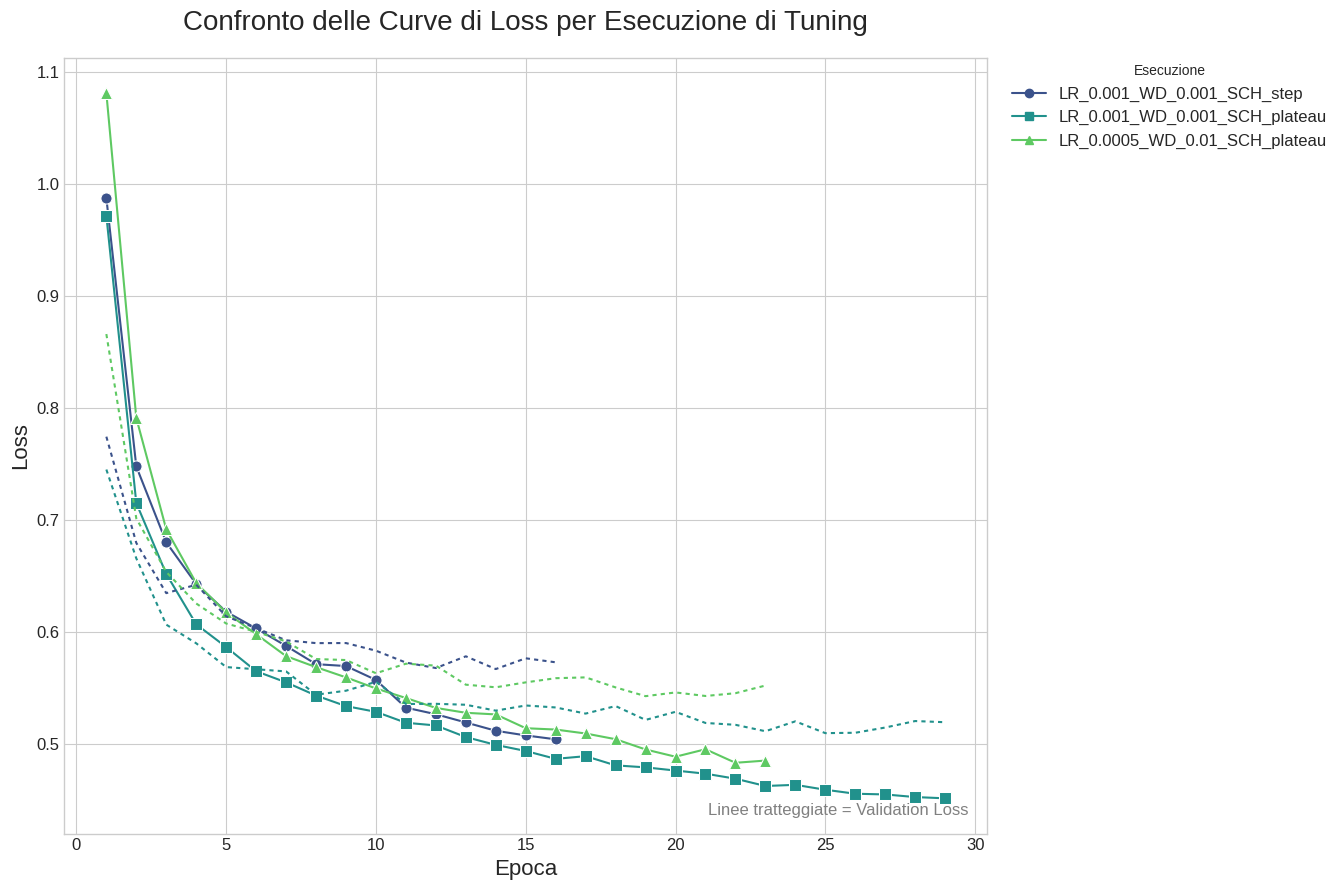

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

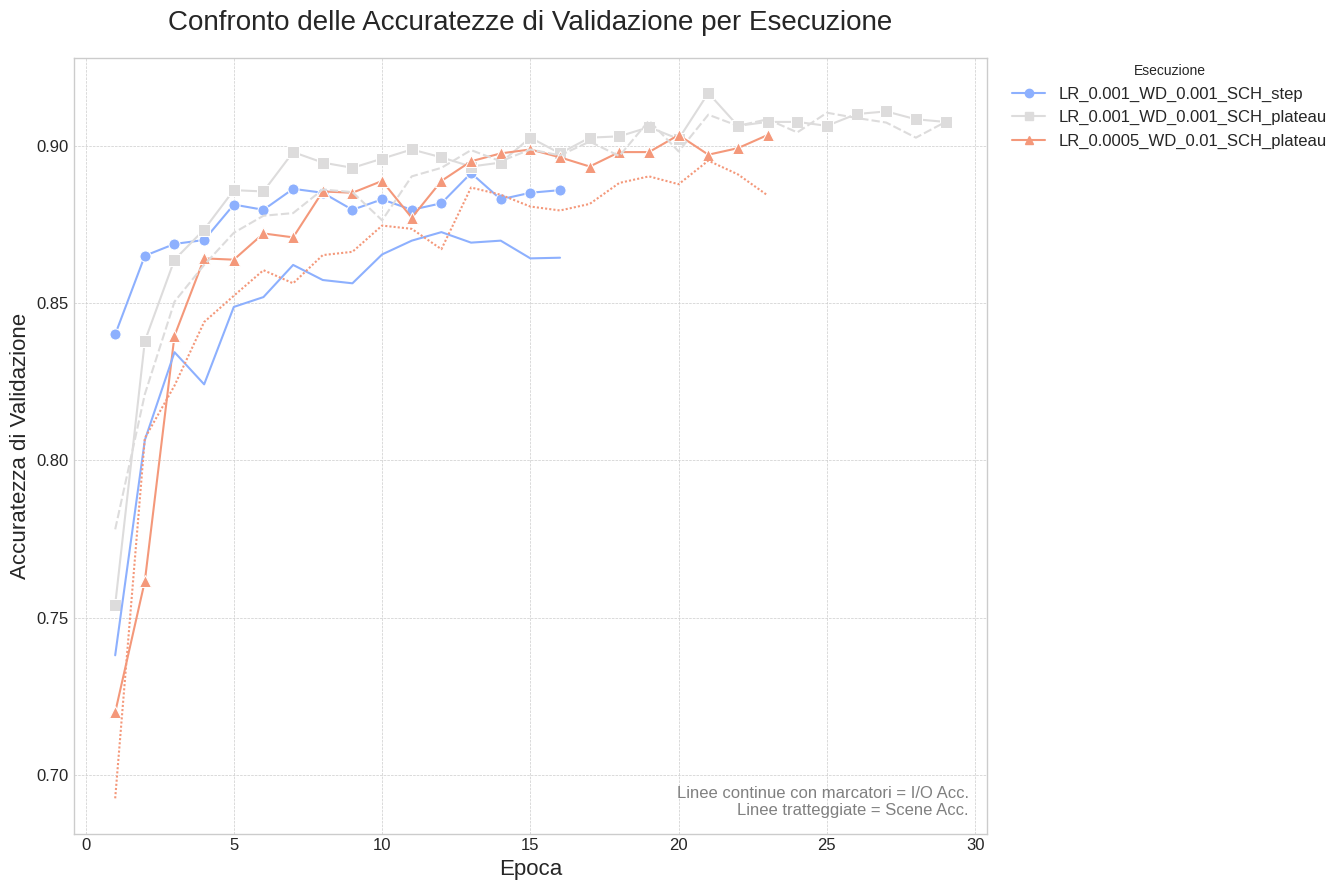

In [22]:
# Assumiamo che 'all_histories' sia disponibile
if 'all_histories' not in locals() or not all_histories:
    print("La variabile 'all_histories' non è stata trovata o è vuota.")
    print("Per favore, esegui prima il ciclo di hyperparameter tuning.")
else:
    # --- 1. Prepara i dati per il plotting ---
    plot_data = []
    for run_name, history in all_histories.items():
        for epoch_data in history:
            epoch_data['run_name'] = run_name
            plot_data.append(epoch_data)
            
    df_history = pd.DataFrame(plot_data)
    df_history['vl_scene_avg'] = (df_history['vl_sc1'] + df_history['vl_sc2']) / 2
    
    # Definiamo gli stili in anticipo per ogni esecuzione
    num_runs = len(df_history['run_name'].unique())
    run_names = df_history['run_name'].unique()
    
    # Palette di colori
    palette_loss = sns.color_palette("viridis", n_colors=num_runs)
    palette_acc = sns.color_palette("coolwarm", n_colors=num_runs)
    
    # Dizionari per mappare ogni esecuzione a uno stile specifico
    markers_map = {name: style for name, style in zip(run_names, ['o', 's', '^', 'P', 'D', 'X'])}


    # --- 2. Plot delle Curve di Loss ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Plottiamo separatamente training e validation loss per un controllo maggiore
    sns.lineplot(data=df_history, x='epoch', y='tr_loss', hue='run_name', 
                 style='run_name', markers=markers_map, dashes=False,
                 ax=ax1, palette=palette_loss, legend='full', markersize=8)
                 
    sns.lineplot(data=df_history, x='epoch', y='vl_loss', hue='run_name',
                 style='run_name', ax=ax1, palette=palette_loss, legend=False,
                 dashes={name: (2, 2) for name in df_history['run_name'].unique()}, markers=False)

    ax1.set_title('Confronto delle Curve di Loss per Esecuzione di Tuning', fontsize=20, pad=20)
    ax1.set_xlabel('Epoca', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.tick_params(axis='both', labelsize=12)
    ax1.legend(title='Esecuzione', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)
    
    plt.text(0.98, 0.02, 'Linee tratteggiate = Validation Loss', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax1.transAxes, color='gray', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


    # --- 3. Plot delle Curve di Accuratezza di Validazione ---
    fig, ax2 = plt.subplots(figsize=(16, 9))
    
    # Definiamo gli stili per questo grafico
    # I/O -> linea continua, Scena -> linea tratteggiata
    # Creiamo un dizionario di stili per ogni combinazione di run_name e tipo di accuratezza
    dashes_map = {}
    for run in run_names:
        dashes_map[run] = "" # Stringa vuota per linea continua (verrà gestito da seaborn)
        
    # I/O -> Linea continua
    sns.lineplot(data=df_history, x='epoch', y='vl_io', hue='run_name', 
                 style='run_name', dashes=False, markers=markers_map, 
                 ax=ax2, palette=palette_acc, markersize=8)
                 
    # Scena -> Linea tratteggiata
    sns.lineplot(data=df_history, x='epoch', y='vl_scene_avg', hue='run_name', 
                 style='run_name', dashes=True, markers=False, 
                 ax=ax2, palette=palette_acc)

    ax2.set_title('Confronto delle Accuratezze di Validazione per Esecuzione', fontsize=20, pad=20)
    ax2.set_xlabel('Epoca', fontsize=16)
    ax2.set_ylabel('Accuratezza di Validazione', fontsize=16)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Migliore gestione della legenda
    handles, labels = ax2.get_legend_handles_labels()
    unique_labels_count = df_history['run_name'].nunique()
    ax2.legend(handles[:unique_labels_count], labels[:unique_labels_count], 
               title='Esecuzione', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)

    plt.text(0.98, 0.02, 'Linee continue con marcatori = I/O Acc.\nLinee tratteggiate = Scene Acc.',
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax2.transAxes, color='gray', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [24]:
def evaluate_model_performance(model, loader, exit_thresholds, execution_mode):
    # No need to load the model state dict inside the loop, do it once outside.
    model.to(device)
    model.eval()
    
    model.if_train = False 

    # Set the thresholds for this evaluation run
    model.exit_thr0 = torch.tensor(exit_thresholds[0], dtype=torch.float32).to(device)
    model.exit_thr1 = torch.tensor(exit_thresholds[1], dtype=torch.float32).to(device)

    # --- Accumulators for Accuracy (existing) ---
    total_samples = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    correct_at_exit = {1: 0, 2: 0, 3: 0}
    correct_io_later = {2: 0, 3: 0}

    # --- NEW: Lists to store labels for F1 score calculation ---
    y_true_io_exit1 = []
    y_pred_io_exit1 = []
    y_true_scene_exit2 = []
    y_pred_scene_exit2 = []
    y_true_scene_final = []
    y_pred_scene_final = []


    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            feats = feats.float().to(device)
            io_lbls = io_lbls.squeeze().to(device)
            sc_lbls = sc_lbls.squeeze().to(device)

            outs, exit_idx = model(feats, execution_mode=execution_mode)
            bsz = feats.size(0)
            total_samples += bsz
            exit_counts[exit_idx] += bsz

            if exit_idx == 1:
                preds = outs[0].argmax(dim=1)
                correct_at_exit[1] += (preds == io_lbls).sum().item()
                # NEW: Collect labels for F1
                y_true_io_exit1.extend(io_lbls.cpu().numpy())
                y_pred_io_exit1.extend(preds.cpu().numpy())
                
            elif exit_idx == 2:
                preds = outs[1].argmax(dim=1)
                correct_at_exit[2] += (preds == sc_lbls).sum().item()
                # NEW: Collect labels for F1
                y_true_scene_exit2.extend(sc_lbls.cpu().numpy())
                y_pred_scene_exit2.extend(preds.cpu().numpy())
                
            else: # exit_idx == 3
                if len(outs) > 2:
                    preds = outs[2].argmax(dim=1)
                    correct_at_exit[3] += (preds == sc_lbls).sum().item()
                    # NEW: Collect labels for F1
                    y_true_scene_final.extend(sc_lbls.cpu().numpy())
                    y_pred_scene_final.extend(preds.cpu().numpy())

            if execution_mode == 'high_power' and (exit_idx == 2 or exit_idx == 3):
                io_preds_if_not_exited = outs[0].argmax(dim=1)
                correct_io_later[exit_idx] += (io_preds_if_not_exited == io_lbls).sum().item()

    # --- Calculate and structure results (Accuracy part is unchanged) ---
    total = total_samples
    n0, n1, nf = exit_counts[1], exit_counts[2], exit_counts[3]
    c0, c1, cf = correct_at_exit[1], correct_at_exit[2], correct_at_exit[3]

    # --- NEW: Calculate F1 Macro scores ---
    # We check if the lists are non-empty before calculating
    f1_io_exit1 = f1_score(y_true_io_exit1, y_pred_io_exit1, average='macro', zero_division=0.0) if y_true_io_exit1 else 0.0
    f1_scene_exit2 = f1_score(y_true_scene_exit2, y_pred_scene_exit2, average='macro', zero_division=0.0) if y_true_scene_exit2 else 0.0
    f1_scene_final = f1_score(y_true_scene_final, y_pred_scene_final, average='macro', zero_division=0.0) if y_true_scene_final else 0.0
    
    # Calculate overall F1 for a comprehensive view (optional)
    overall_y_true = y_true_io_exit1 + y_true_scene_exit2 + y_true_scene_final
    overall_y_pred = y_pred_io_exit1 + y_pred_scene_exit2 + y_pred_scene_final
    # Note: This overall F1 mixes I/O and Scene labels, which might not be directly comparable.
    # It's more of a general performance indicator.

    results = {
        'mode': execution_mode,
        'thresholds': tuple(exit_thresholds),
        'exit_rates': {
            'exit1_rate': n0 / total * 100 if total else 0,
            'exit2_rate': n1 / total * 100 if total else 0,
            'final_rate': nf / total * 100 if total else 0,
        },
        'accuracy_at_exit': {
            'io_acc_@_exit1': c0 / n0 if n0 else 0,
            'scene_acc_@_exit2': c1 / n1 if n1 else 0,
            'scene_acc_@_final': cf / nf if nf else 0,
            'overall_acc': (c0 + c1 + cf) / total if total else 0,
        },
        # NEW: Add F1 scores to results
        'f1_macro_at_exit': {
            'f1_io_@_exit1': f1_io_exit1,
            'f1_scene_@_exit2': f1_scene_exit2,
            'f1_scene_@_final': f1_scene_final,
        }
    }
    
    # --- Print Results ---
    print(f"--- Evaluation for Mode: {results['mode'].upper()} | Thresholds: {results['thresholds']} ---")
    print(f"Exit Rates (%): {results['exit_rates']}")
    print(f"Accuracy at Each Exit: {results['accuracy_at_exit']}")
    # NEW: Print F1 scores
    print(f"F1 Macro at Each Exit: {results['f1_macro_at_exit']}")
    
    if execution_mode == 'high_power':
        io_accuracy_non_exited = {
            'io_acc_of_samples_exiting_@2': correct_io_later[2] / n1 if n1 else 0,
            'io_acc_of_samples_exiting_@3': correct_io_later[3] / nf if nf else 0,
        }
        print(f"I/O Accuracy for Samples Passing Exit 1: {io_accuracy_non_exited}")
    
    print("-"*(60+len(str(results['thresholds']))))
    return results

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.001_WD_0.001_SCH_plateau/best_model.pth" # <--- UPDATE THIS PATH

# Enter the threshold combination that gave you the best results on the VALIDATION set.
BEST_THRESHOLDS = [0.99, 0.98] # <--- UPDATE THESE THRESHOLDS

# Instantiate the model structure
train_shape = train_ds[0][0].shape
model = EarlyExitCNN1D_depthwiseSep(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_),
    exit_thresholds=[1, 1]
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# Test the 'low_power' mode on the unseen test data
print("\n" + "="*25 + " FINAL TEST: LOW POWER MODE " + "="*25)
evaluate_model_performance(
    model, 
    test_loader,  # Use the test set
    exit_thresholds=[0, 0], 
    execution_mode='low_power'
)

# Test the 'high_power' mode using the best thresholds found during validation
print("\n" + "="*25 + " FINAL TEST: HIGH POWER MODE " + "="*25)
evaluate_model_performance(
    model, 
    test_loader,  # Use the test set
    exit_thresholds=BEST_THRESHOLDS, 
    execution_mode='high_power'
)


========================= FINAL TEST: LOW POWER MODE =========================
--- Evaluation for Mode: LOW_POWER | Thresholds: (0, 0) ---
Exit Rates (%): {'exit1_rate': 100.0, 'exit2_rate': 0.0, 'final_rate': 0.0}
Accuracy at Each Exit: {'io_acc_@_exit1': 0.8983333333333333, 'scene_acc_@_exit2': 0, 'scene_acc_@_final': 0, 'overall_acc': 0.8983333333333333}
F1 Macro at Each Exit: {'f1_io_@_exit1': 0.8697689644497739, 'f1_scene_@_exit2': 0.0, 'f1_scene_@_final': 0.0}
------------------------------------------------------------------

========================= FINAL TEST: HIGH POWER MODE =========================
--- Evaluation for Mode: HIGH_POWER | Thresholds: (0.99, 0.98) ---
Exit Rates (%): {'exit1_rate': 6.666666666666667, 'exit2_rate': 65.33333333333333, 'final_rate': 28.000000000000004}
Accuracy at Each Exit: {'io_acc_@_exit1': 0.925, 'scene_acc_@_exit2': 0.9068877551020408, 'scene_acc_@_final': 0.9136904761904762, 'overall_acc': 0.91}
F1 Macro at Each Exit: {'f1_io_@_exit1': 0.9

{'mode': 'high_power',
 'thresholds': (0.99, 0.98),
 'exit_rates': {'exit1_rate': 6.666666666666667,
  'exit2_rate': 65.33333333333333,
  'final_rate': 28.000000000000004},
 'accuracy_at_exit': {'io_acc_@_exit1': 0.925,
  'scene_acc_@_exit2': 0.9068877551020408,
  'scene_acc_@_final': 0.9136904761904762,
  'overall_acc': 0.91},
 'f1_macro_at_exit': {'f1_io_@_exit1': 0.9016191842590695,
  'f1_scene_@_exit2': 0.8969621171020447,
  'f1_scene_@_final': 0.8991534809095321}}

In [ ]:
print("--- Distribuzione delle Scene ---")
print("Training Set:\n", train_df['Scene Identification'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['Scene Identification'].value_counts(normalize=True))
print("\nTest Set:\n", test_df['Scene Identification'].value_counts(normalize=True))

print("\n--- Distribuzione I/O ---")
print("Training Set:\n", train_df['I/O Detection'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['I/O Detection'].value_counts(normalize=True))
print("\nTest Set:\n", test_df['I/O Detection'].value_counts(normalize=True))

### Model Performance Analysis: Dual-Mode Operation

This analysis evaluates the model's effectiveness in its two primary operating modes: a `HIGH_POWER` mode for full, conditional classification and a `LOW_POWER` mode for efficient, I/O-only detection.

The evaluation is based on the following results obtained with a high-power configuration using thresholds of `(0.95, 0.7)`.

```
--- Evaluation for Mode: HIGH_POWER | Thresholds: (0.95, 0.7) ---
Exit Rates: {'exit1_rate': 0.0893..., 'exit2_rate': 0.9106..., 'final_rate': 0.0}
Accuracy at Each Exit: {'io_acc_@_exit1': 0.7395..., 'scene_acc_@_exit2': 0.8429..., 'overall_acc': 0.8336...}
I/O Accuracy for Samples Passing Exit 1: {'io_acc_of_samples_exiting_@2': 0.9059...}
```

### High-Power Mode Analysis (Conditional Classification)

In this mode, the model functions as an intelligent, two-stage classifier. The first exit acts as a "confidence gate" to decide whether performing the more expensive Scene Detection is worthwhile.

*   **Low-Confidence Path (Immediate Exit):**
    *   For **8.9%** of samples, the model's confidence in the initial I/O detection was low (`<= 0.95`).
    *   To save energy, these samples were immediately exited, achieving an **I/O Detection accuracy of 74.0%**.

*   **High-Confidence Path (Full Classification):**
    *   For the remaining **91.1%** of samples, I/O confidence was high (`> 0.95`), and the model proceeded to the second stage.
    *   On this "high-confidence" subset, the model achieved excellent results:
        *   A **Scene Detection accuracy of 84.3%**.
        *   A "what-if" **I/O Detection accuracy of 90.6%**, confirming that the model was correct to be confident in its initial assessment.

### Low-Power Mode Analysis (I/O Only)

In this mode, the goal is maximum battery preservation. The model is forced to *always* stop after the first stage, providing only an I/O detection for 100% of the samples.

*   The overall accuracy for this efficient mode is **89.1%**.

In [25]:
def count_parameters(model):
    """Counts the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- How to use it in your script ---

# First, instantiate your model (you've already done this)
# Make sure to use the same parameters as in your training script
train_shape = train_ds[0][0].shape
n_io = len(train_ds.io_label_encoder.classes_)
n_scene = len(train_ds.scene_label_encoder.classes_)

model = EarlyExitCNN1D_depthwiseSep(
    if_train=True,
    train_shape=train_shape,
    n_io=n_io,
    n_scene=n_scene,
    exit_thresholds=[1, 1] # Thresholds don't affect model size
).to(device)

# Now, call the function to get the count
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:}")

estimated_size = total_params * 4 / 1000 # FP32 precision
print(f"Estimated Size: {estimated_size:,} KB")

Total Trainable Parameters: 13334
Estimated Size: 53.336 KB


# Dynamic Threshold

# TODO
- Dynamic Thresholds: Instead of fixed thresholds, consider making them learnable parameters of the network. This allows the model to dynamically adjust the confidence needed for an early exit based on the input's complexity.
- Data Augmentation for Time-Series Data
- early stopping in the training procedure
- attention mechanism

# TO DELETE THE /kaggle/working/ FILES

In [33]:
import shutil

directory_path = "/kaggle/working/"

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory {directory_path}")
else:
    print(f"Directory {directory_path} not found")

Deleted directory /kaggle/working/model1_eecnn
